### This notebook is about data wrangling for 1st capstone project, the goal is to predict airbnb listing price at Austin, TX. The dataset was taken from insideairbnb.com (http://insideairbnb.com/get-the-data.html)

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from shapely.geometry import Point

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

./111capstone1_data_wrangling.ipynb
./capstone1_data_story.ipynb
./capstone1_data_wrangling.ipynb
./listings.csv
./listings_clean.csv
./neighbourhoods.geojson
./Zipcodes.geojson
./.ipynb_checkpoints\capstone1_data_story-checkpoint.ipynb
./.ipynb_checkpoints\capstone1_data_wrangling-checkpoint.ipynb


In [117]:
listings_df = pd.read_csv('./listings_clean.csv')
print(listings_df.shape)
listings_df.head(5)


(11250, 38)


,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_identity_verified,zipcode,latitude,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
0,2265,2466,2008-08-23,within a few hours,100%,t,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,78702,30.27750,...,93.0,9.0,10.0,10.0,10.0,8.0,9.0,f,strict_14_with_grace_period,0.18
1,5245,2466,2008-08-23,within a few hours,100%,t,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,78702,30.27577,...,91.0,10.0,8.0,10.0,9.0,10.0,9.0,f,strict_14_with_grace_period,0.07
2,5456,8028,2009-02-16,within a few hours,100%,t,"['email', 'phone', 'reviews', 'kba']",t,78702,30.26112,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,3.90
3,5769,8186,2009-02-19,within an hour,100%,t,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,78729,30.45596,...,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,2.20
4,6413,13879,2009-04-17,within an hour,100%,t,"['email', 'phone', 'reviews', 'jumio', 'offlin...",f,78704,30.24829,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,0.86


In [118]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11250 entries, 0 to 11249
Data columns (total 38 columns):
id                             11250 non-null int64
host_id                        11250 non-null int64
host_since                     11250 non-null object
host_response_time             11250 non-null object
host_response_rate             11250 non-null object
host_is_superhost              11250 non-null object
host_verifications             11250 non-null object
host_identity_verified         11250 non-null object
zipcode                        11250 non-null int64
latitude                       11250 non-null float64
longitude                      11250 non-null float64
property_type                  11250 non-null object
room_type                      11250 non-null object
accommodates                   11250 non-null int64
bathrooms                      11250 non-null float64
bedrooms                       11250 non-null float64
beds                           11250 non-nu

### Now let's take a closer look at these features

#### how many listings does each host have


In [119]:
host_listings = listings_df.groupby('host_id').count()['id'].sort_values(ascending=False) 
host_listings.head(10)

host_id
104309976    165
219500569    140
4962900       84
114353388     82
8167447       77
118565935     70
109638288     68
1739801       49
194953121     41
138398089     35
Name: id, dtype: int64

#### Wow, it is quite impressive hosts can have so many properties to list on airbnb. Let's visualize this

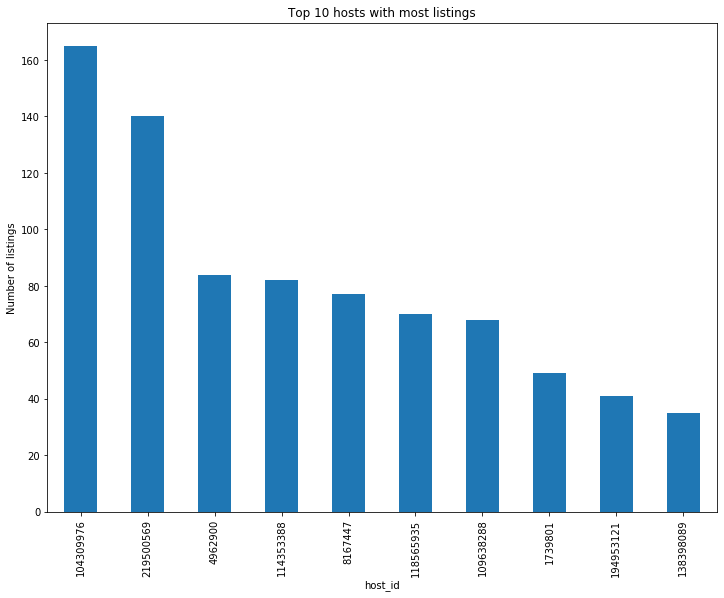

In [120]:
plt.figure(figsize=(12,9))
plt.title('Top 10 hosts with most listings')
plt.xlabel('Host id')
plt.ylabel('Number of listings')
host_listings.head(10).plot(kind ='bar')

#### How many hosts have more than 1 listings?

In [121]:
len(host_listings[host_listings>1]) # 1279 hosts have more than 1 listings

1279

#### how many unique host do we have?

In [122]:
len(listings_df['host_id'].unique()) # total unique hosts are 7587

7587

It looks like 1279/7587 = 17% hosts have more than 1 listing property on Airbnb<br>
#### Since when do they become host?

In [123]:
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])

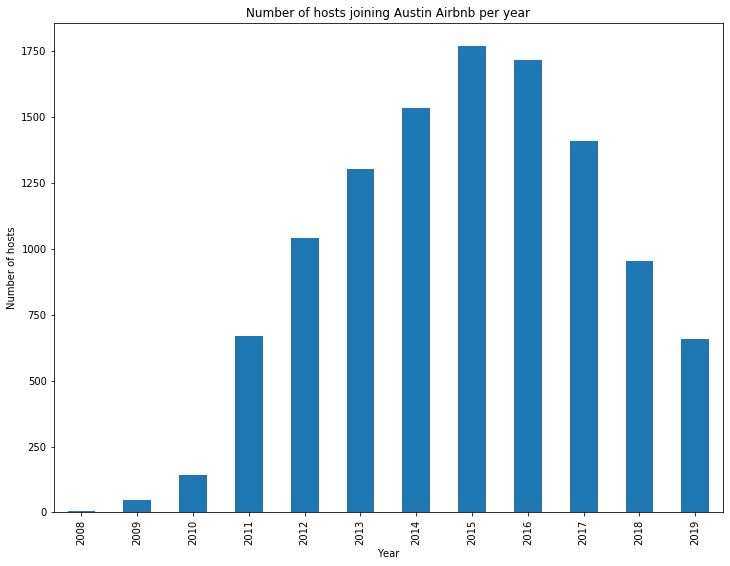

In [124]:
host_since = listings_df['host_since'].dropna()
host_year = host_since.apply(lambda x: x.year)
plt.figure(figsize=(12,9))
plt.title('Number of hosts joining Austin Airbnb per year')
plt.xlabel('Year')
plt.ylabel('Number of hosts')
host_year.value_counts().sort_index().plot(kind='bar')

### So it seems more people joined airbnb each year to become a host until 2015, after which new host each year starts to decline, market is saturated?

#### How responsive are these hosts?

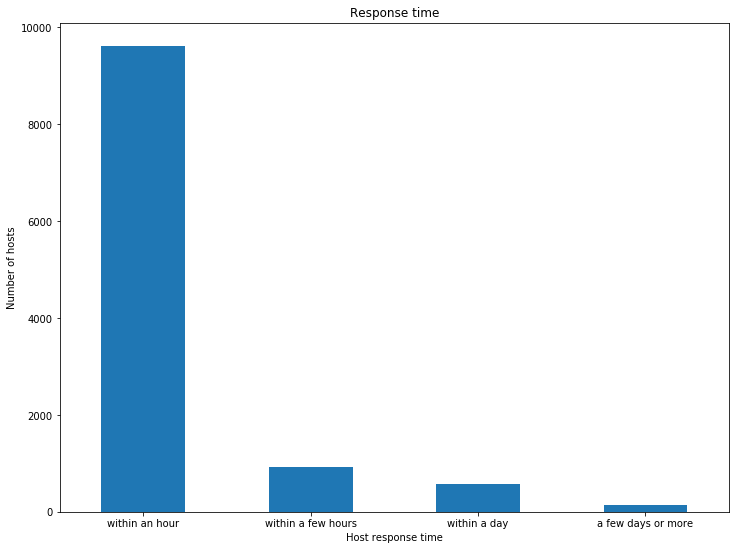

In [125]:
plt.figure(figsize=(12,9))
plt.title('Response time')
plt.xlabel('Host response time')
plt.ylabel('Number of hosts')
listings_df['host_response_time'].value_counts().plot(kind='bar',rot=0)

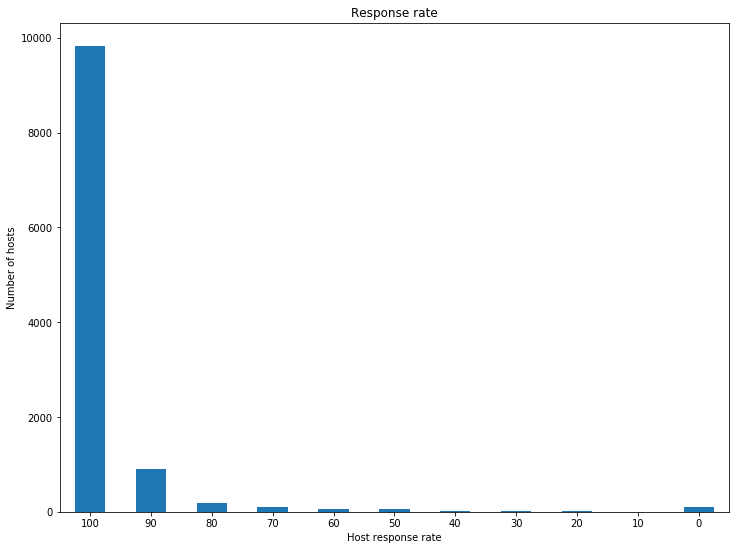

In [126]:
plt.figure(figsize=(12,9))
plt.title('Response rate')
plt.xlabel('Host response rate')
plt.ylabel('Number of hosts')
host_response_rate = listings_df['host_response_rate'].dropna().apply(lambda x: int(x[0:-1])//10*10)
host_response_rate.value_counts().sort_index(ascending=False).plot(kind='bar',rot=0)

Not suprisingly, most host are very responsive. The response time is mostly within an hour, and response rate is close to 100%, 

#### How many hosts are superhosts?

f    0.642222
t    0.357778
Name: host_is_superhost, dtype: float64

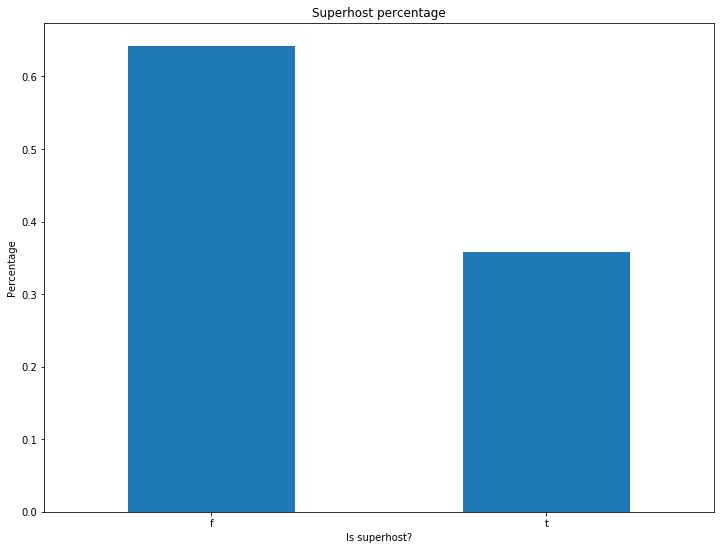

In [127]:
plt.figure(figsize=(12,9))
plt.title('Superhost percentage')
plt.xlabel('Is superhost?')
plt.ylabel('Percentage')
listings_df['host_is_superhost'].value_counts(normalize = True).plot(kind='bar',rot=0)
listings_df['host_is_superhost'].value_counts(normalize = True)

About 36% hosts are superhosts. What is a superhost anyway?

Answers from airbnb (https://www.airbnb.com/help/article/828/what-is-a-superhost)<br>
   _What is a Superhost?<br>
    Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests.<br>
    Once a host reaches Superhost status, a badge superhost badge will automatically appear on their listing and profile to help you identify them.<br>
    We check Superhosts’ activity four times a year, to ensure that the program highlights the people who are most dedicated to providing outstanding hospitality.<br>_
    
#### How many hosts are verified?


f    0.503733
t    0.496267
Name: host_identity_verified, dtype: float64

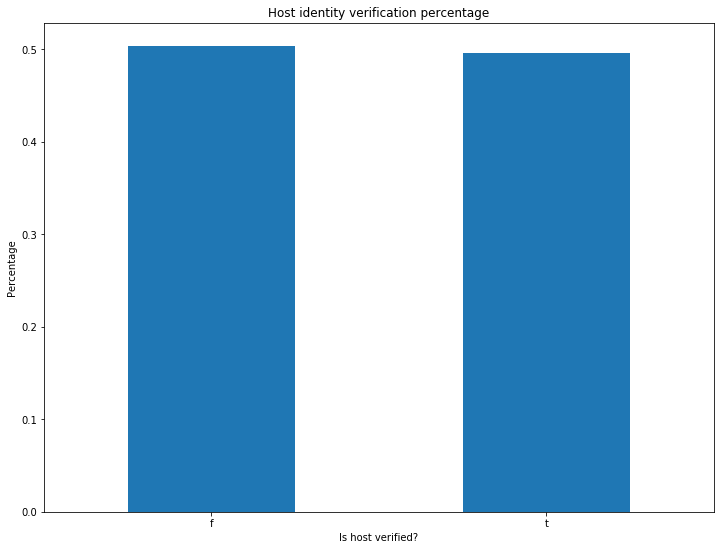

In [128]:
plt.figure(figsize=(12,9))
plt.title('Host identity verification percentage')
plt.xlabel('Is host verified?')
plt.ylabel('Percentage')
listings_df['host_identity_verified'].value_counts(normalize = True).plot(kind='bar',rot=0)
listings_df['host_identity_verified'].value_counts(normalize = True)

About half of the host are verifed. By what methods?

In [129]:
host_veri_set = (set(listings_df['host_verifications'].dropna()))
uniq_veri = set()
[uniq_veri.update(set(eval(i))) for i in host_veri_set if eval(i)]
print('Total verification methods =  ', len(uniq_veri))
print('host verification method include: ', ', '.join(uniq_veri))

Total verification methods =   20
host verification method include:  amex, jumio, selfie, weibo, reviews, sent_id, photographer, kba, manual_online, government_id, identity_manual, google, sesame, sesame_offline, work_email, facebook, manual_offline, offline_government_id, phone, email


In [130]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11250 entries, 0 to 11249
Data columns (total 38 columns):
id                             11250 non-null int64
host_id                        11250 non-null int64
host_since                     11250 non-null datetime64[ns]
host_response_time             11250 non-null object
host_response_rate             11250 non-null object
host_is_superhost              11250 non-null object
host_verifications             11250 non-null object
host_identity_verified         11250 non-null object
zipcode                        11250 non-null int64
latitude                       11250 non-null float64
longitude                      11250 non-null float64
property_type                  11250 non-null object
room_type                      11250 non-null object
accommodates                   11250 non-null int64
bathrooms                      11250 non-null float64
bedrooms                       11250 non-null float64
beds                           1125

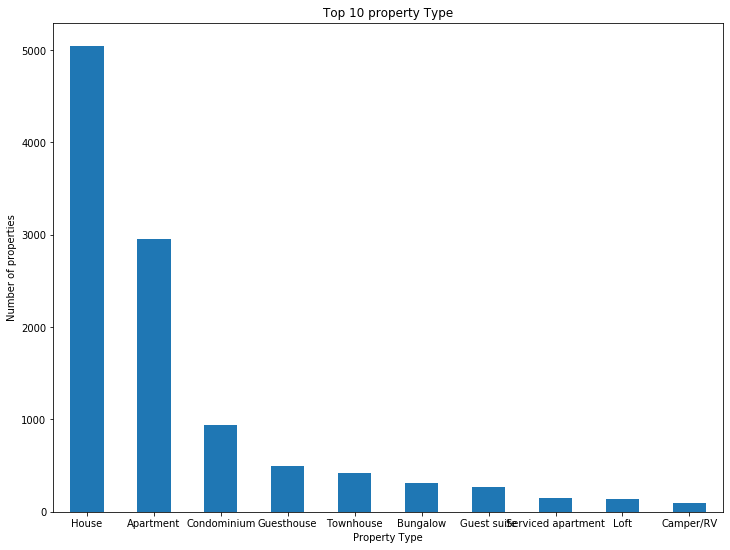

In [131]:
plt.figure(figsize=(12,9))
plt.title('Top 10 property Type')
plt.xlabel('Property Type')
plt.ylabel('Number of properties')
listings_df['property_type'].value_counts().head(10).plot(kind='bar',rot=0)

#### Majority of the properties listed on airbnb are house, apartment and condo etc, which is typical what airbnb is about

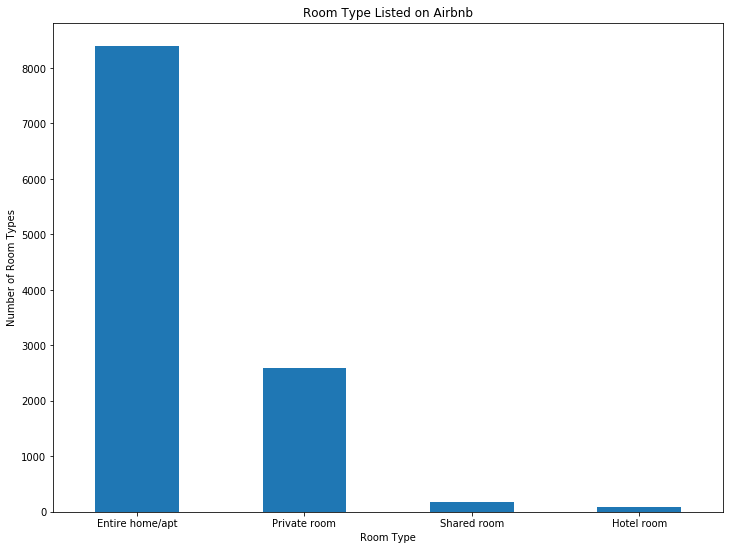

In [132]:
plt.figure(figsize=(12,9))
plt.title('Room Type Listed on Airbnb')
plt.xlabel('Room Type')
plt.ylabel('Number of Room Types')
listings_df['room_type'].value_counts().plot(kind='bar',rot=0)

#### According to airbnb, entire home/apt means you have complete space to your self, private room means private room for sleeping and may need to share some space with others, and shared room means you may need to sleep in a shared space. Majority of the room type is entire home means you have complete privacy

18    3
19    2
20    5
21    3
24    2
25    1
28    2
30    2
32    2
33    1
Name: accommodates, dtype: int64

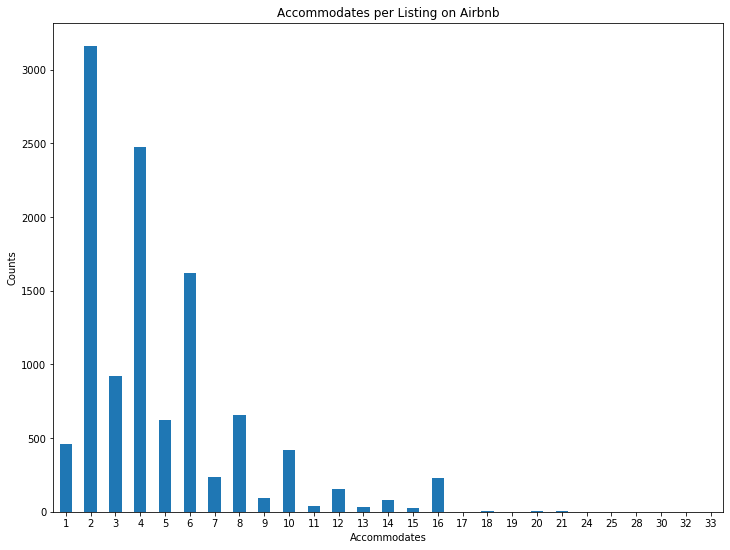

In [133]:
plt.figure(figsize=(12,9))
plt.title('Accommodates per Listing on Airbnb')
plt.xlabel('Accommodates')
plt.ylabel('Counts')
listings_df['accommodates'].value_counts().sort_index().plot(kind='bar',rot=0)
listings_df['accommodates'].value_counts().sort_index().tail(10)

#### A few things to notice for the accommodates
1) Most of the listings are for small group of people (<6), which is the typical case for friends and family go out for a trip, and also typical type for a home/apartment to be able to accommodate

2) More accommodates with even numbers (2/4/6/8 etc) than with odd numbers (1/3/5/7 etc)

3) There are a few listings that can accommodate a lot more peoples (>17)

4) There is another feature called 'guests_included' which is different from this one. The difference is 'accommodates' is the total guest that the property can have, where 'guests_included' is the total guest that this listing allows. In case of shared rooms, 'guests_included' will be less than 'accommodates' since the same property can be occupied by different groups

In [134]:
temp_list = []
[temp_list.extend((i.replace('"','').replace('{','').replace('}','').split(','))) for i in listings_df['amenities']]
list_amenities = [i for i in temp_list if i] # get a list of all amenities on airbnb
set_amenities = set(list_amenities)  # get unique amenities on airbnb

#### Let's conut what are the most common amentities on Airbnb!

In [135]:
amen_dict = {}  
for i in list_amenities:
    if i in amen_dict:
        amen_dict[i] += 1
    else:
        amen_dict[i] = 1

amen_list = sorted(amen_dict.items(), key = lambda x: x[1], reverse=True)

[amen_list[i] for i in range(20)]

[('Air conditioning', 11053),
 ('Wifi', 10881),
 ('Heating', 10757),
 ('Essentials', 10485),
 ('Kitchen', 10482),
 ('Smoke detector', 10333),
 ('TV', 9510),
 ('Free parking on premises', 9235),
 ('Shampoo', 9131),
 ('Washer', 9104),
 ('Dryer', 9058),
 ('Hangers', 8878),
 ('Hair dryer', 8139),
 ('Laptop friendly workspace', 8053),
 ('Iron', 8036),
 ('Fire extinguisher', 7760),
 ('Carbon monoxide detector', 7449),
 ('Hot water', 6261),
 ('Refrigerator', 5504),
 ('Dishes and silverware', 5255)]

#### The most common ones are like AC/Heating, Wifi, TV, Free parking, Washer/Dryer/Iron/Hanger

In [136]:
cols = ['price','security_deposit','cleaning_fee']
for col in cols:
    listings_df[col] = listings_df[col].apply(lambda x: float(x[1:].replace(',','')))
    

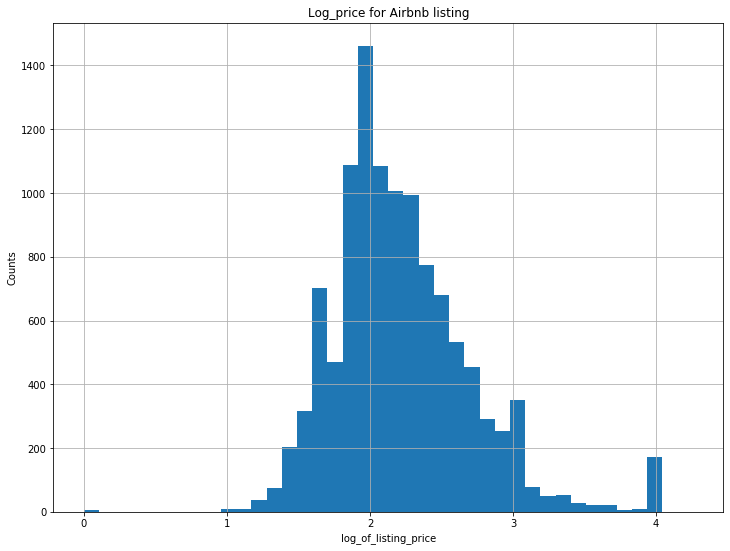

In [137]:
from  math import log10
listings_df = listings_df.loc[listings_df.price>0]
listings_df['price_log'] = listings_df['price'].apply(lambda x: log10(x))
plt.figure(figsize=(12,9))
plt.title('Log_price for Airbnb listing')
plt.xlabel('log_of_listing_price')
plt.ylabel('Counts')
listings_df['price_log'].hist(bins=40)

#### From the log of the listing price, most of the listing price range from ~100 to a few hundreds. However, there is a small peak at around \$10000, also, some listings have price for only a few dollars

The distribution of the log_price, is more or less symmetric peaked at about $100

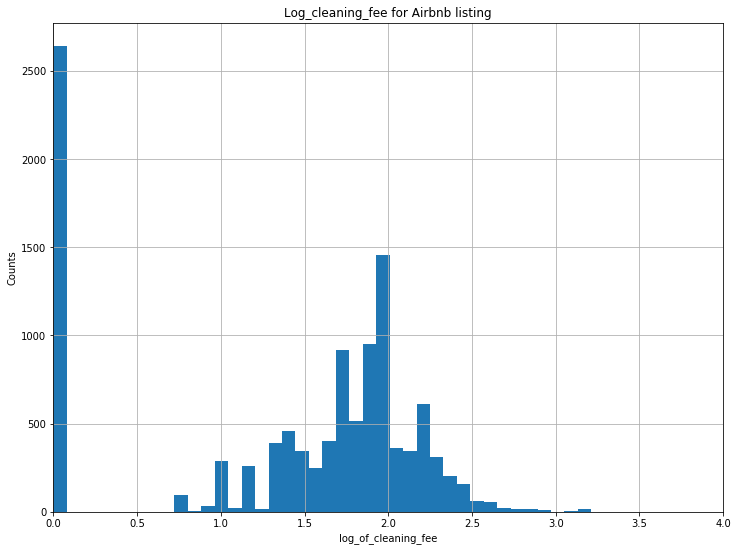

In [138]:
plt.figure(figsize=(12,9))
listings_df['cleaning_fee_log'] = listings_df['cleaning_fee'].apply(lambda x: log10(x+1))
plt.title('Log_cleaning_fee for Airbnb listing')
plt.xlabel('log_of_cleaning_fee')
plt.ylabel('Counts')
plt.xlim(0,4)
listings_df['cleaning_fee_log'].hist(bins=40)

#### Quite some listings does not charge a cleaning fee. For these do charge, the fee is around $100 

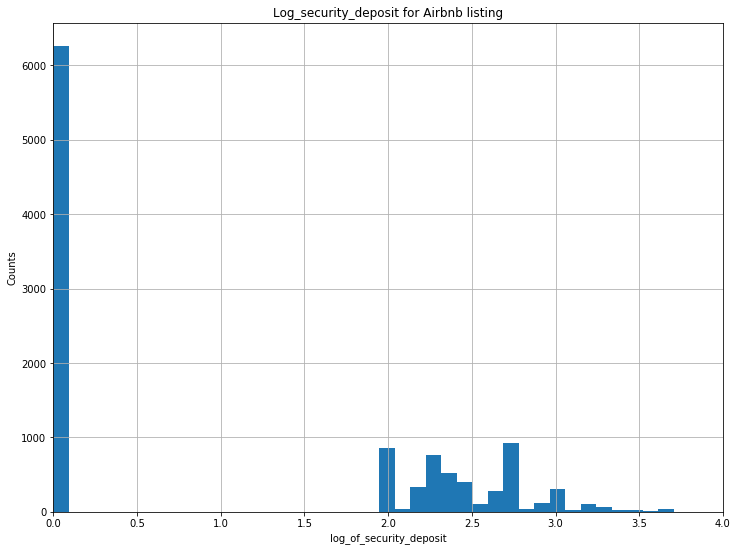

In [139]:
plt.figure(figsize=(12,9))
listings_df['security_deposit_log'] = listings_df['security_deposit'].apply(lambda x: log10(x+1))
plt.title('Log_security_deposit for Airbnb listing')
plt.xlabel('log_of_security_deposit')
plt.ylabel('Counts')
plt.xlim(0,4)
listings_df['security_deposit_log'].hist(bins=40)

#### Again, quite some listings does not charge a security deposit. For these do charge, the fee is mostly between $\$100$ to $\$1000$

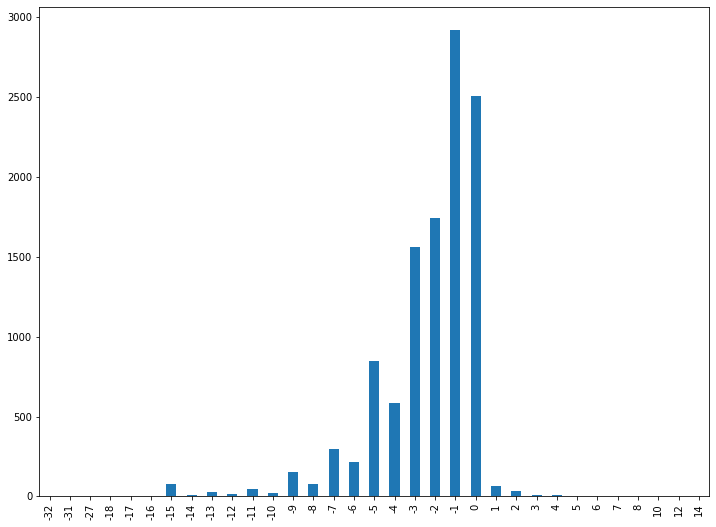

In [140]:
plt.figure(figsize=(12,9))
a = listings_df['guests_included'] - listings_df['accommodates']
a.value_counts().sort_index().plot(kind='bar')


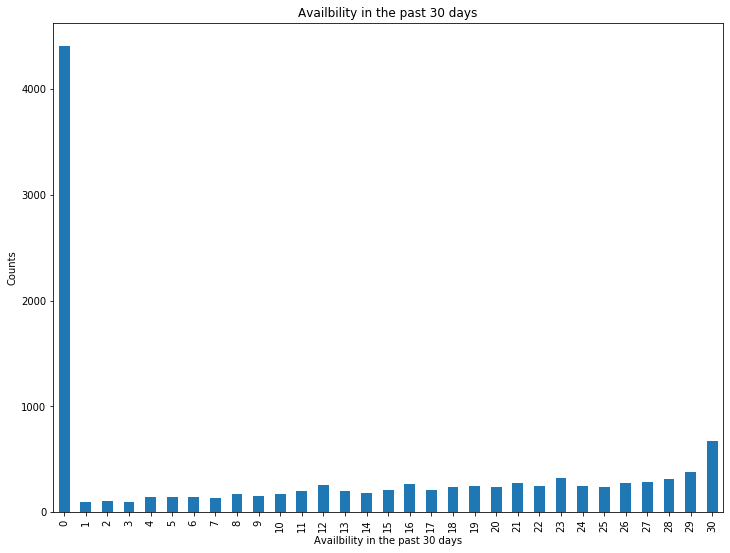

In [141]:
plt.figure(figsize=(12,9))
plt.title('Availbility in the past 30 days')
plt.xlabel('Availbility in the past 30 days')
plt.ylabel('Counts')
listings_df['availability_30'].value_counts().sort_index().plot(kind='bar')


#### The most common availability in the past 30 days are 0, meaning not available at all. The next common one is 30, meaning they are always available. So there is a big distinction on the properties availbility

{'whiskers': [<matplotlib.lines.Line2D at 0x1f630384b08>,
 'caps': [<matplotlib.lines.Line2D at 0x1f630388a88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f630381fc8>],
 'medians': [<matplotlib.lines.Line2D at 0x1f63038da08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f63038db08>],
 'means': []}

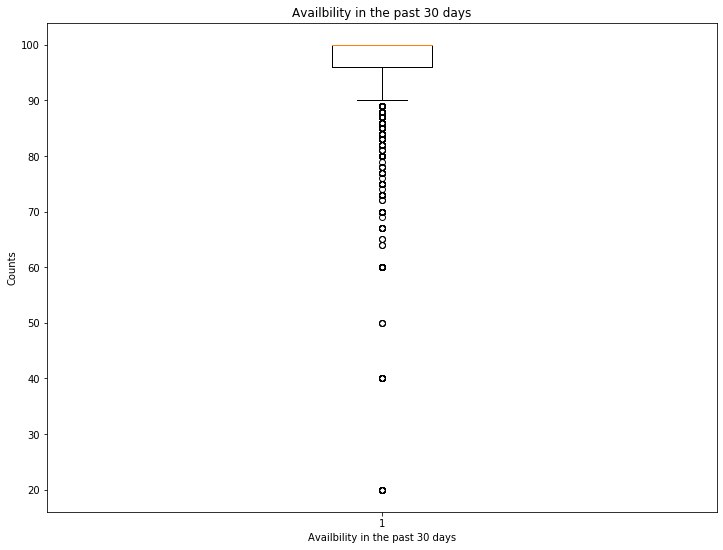

In [142]:
plt.figure(figsize=(12,9))
plt.title('Availbility in the past 30 days')
plt.xlabel('Availbility in the past 30 days')
plt.ylabel('Counts')
#listings_df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar')
#listings_df['review_scores_rating'].plot(kind='boxplot', bins=20)
plt.boxplot(listings_df['review_scores_rating'])

In [143]:
review_column = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
listings_df[review_column].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,11244.000000,11244.000000,11244.000000,11244.000000,11244.000000,11244.000000,11244.000000
mean,96.994486,9.825685,9.702953,9.882960,9.892387,9.825507,9.687300
std,6.215107,0.605670,0.737182,0.533497,0.499024,0.530292,0.704779
min,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
50%,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


#### Overall the review scores are really high

In [144]:
listings_df['instant_bookable'].value_counts()

t    5738
f    5506
Name: instant_bookable, dtype: int64

#### About half of the listings are instant bookable

In [145]:
listings_df['cancellation_policy'].value_counts()

strict_14_with_grace_period    4379
flexible                       3526
moderate                       3107
super_strict_30                 200
luxury_moderate                  21
super_strict_60                  11
Name: cancellation_policy, dtype: int64

#### The most common cancellation policies are strict_14_with_grace_period, flexible, and moderate.

### Next, I will plot each listing based on its location and overlay with map, so we can have a visualliation of the properties price with respect to its location. The listings are grouped by zipcode, and a mean price will be cacluated to color code the area.

In [195]:
austin_map = gpd.read_file("neighbourhoods.geojson")
austin_map["zipcode"] = austin_map["neighbourhood"].astype(int)
austin_map.drop(['neighbourhood_group','neighbourhood'],axis=1,inplace=True)

In [199]:
listings_df["Point"] = listings_df.apply(lambda row:  Point(row["longitude"],     row["latitude"]), axis=1)
listings_df2 = gpd.GeoDataFrame(listings_df, geometry="Point")

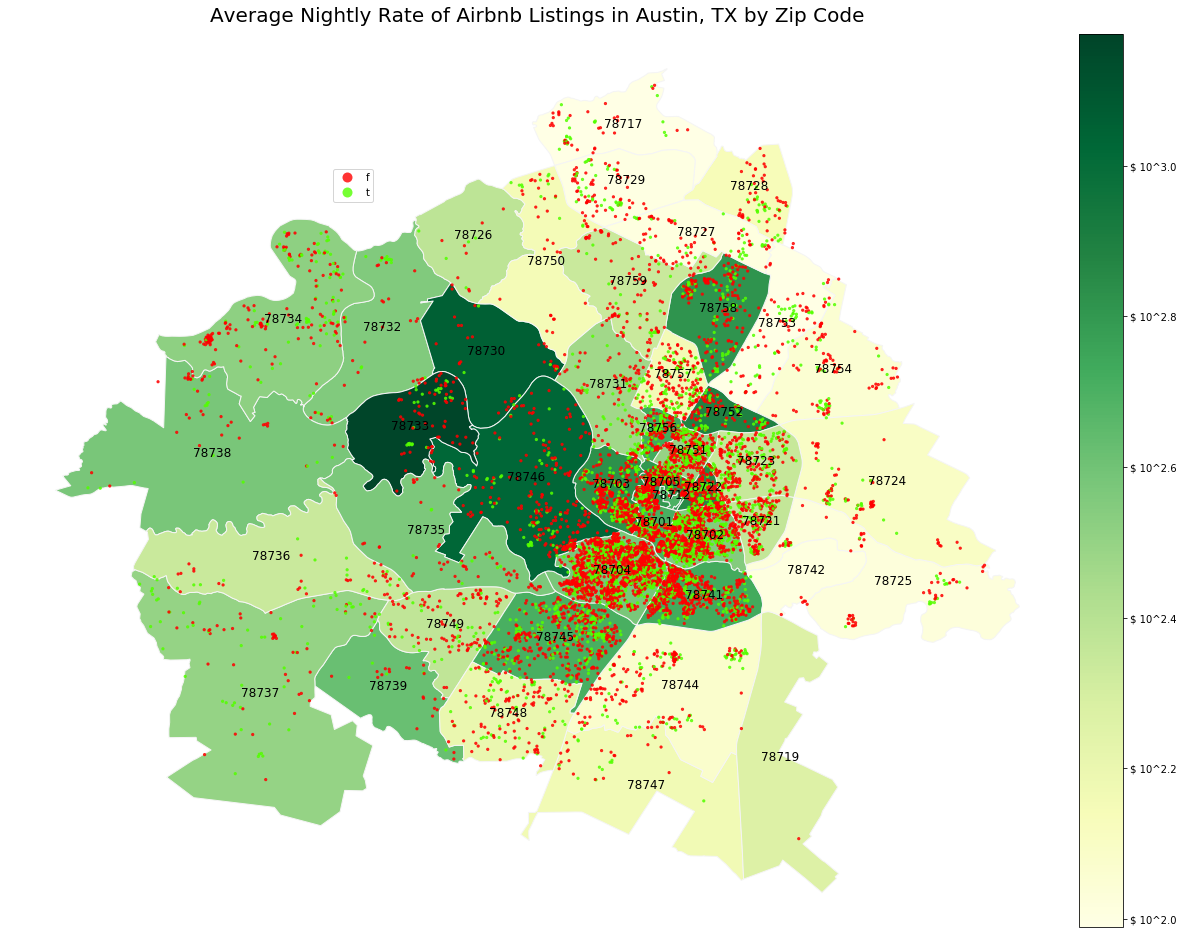

In [201]:
price_df = listings_df.pivot_table(index='zipcode',values='price',aggfunc='mean')
price_df['log_mean_price'] = price_df['price'].apply(lambda x: log10(x))
price_df = pd.merge(austin_map, price_df, how="left", on="zipcode")
price_df = price_df.set_index("zipcode")
fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="log_mean_price", cmap="YlGn", \
                     edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["log_mean_price"].min()
max_price = price_df["log_mean_price"].max()

gradient = plt.cm.ScalarMappable(cmap="YlGn", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

listings_df2.plot(ax=base, cmap="prism", marker="o", markersize=5, \
                 alpha=.8, column="host_is_superhost", \
                 categorical=True, legend=True)

cbar.ax.set_yticklabels(["$ 10^" + i.get_text() for i in cbar.ax.get_yticklabels()])
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Average Nightly Rate of Airbnb Listings in Austin, TX by Zip Code", \
          fontdict={"fontsize":20})

plt.show()